Automatically created module for IPython interactive environment
Distorting image...
Extracting reference patches...
done in 0.06s.
Learning the dictionary...
done in 6.59s.
Extracting noisy patches... 
done in 0.02s.
Orthogonal Matching Pursuit
1 atom...
done in 6.14s.
Orthogonal Matching Pursuit
2 atoms...
done in 12.54s.
Least-angle regression
5 atoms...
done in 76.01s.
Thresholding
 alpha=0.1...
done in 0.72s.


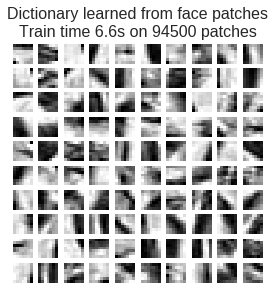

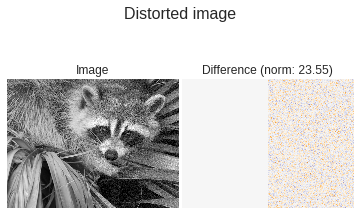

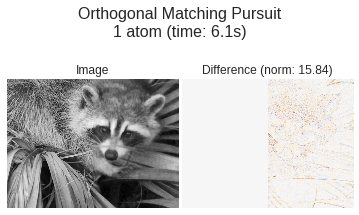

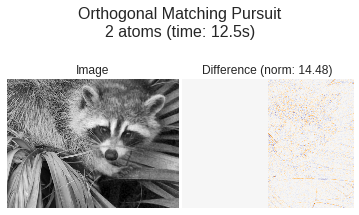

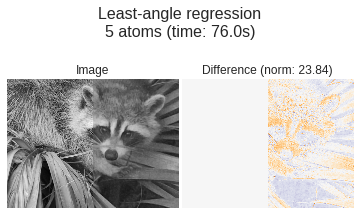

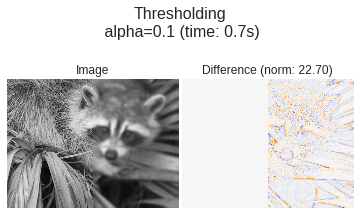

In [6]:
print(__doc__)

from time import time

import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

from sklearn.decomposition import MiniBatchDictionaryLearning
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.feature_extraction.image import reconstruct_from_patches_2d


try:  # SciPy >= 0.16 have face in misc
    from scipy.misc import face
    face = face(gray=True)
except ImportError:
    face = sp.face(gray=True)

# Convert from uint8 representation with values between 0 and 255 to
# a floating point representation with values between 0 and 1.
face = face / 255.

# downsample for higher speed
face = face[::2, ::2] + face[1::2, ::2] + face[::2, 1::2] + face[1::2, 1::2]
face /= 4.0
height, width = face.shape

# Distort the right half of the image
print('Distorting image...')
distorted = face.copy()
distorted[:, width // 2:] += 0.075 * np.random.randn(height, width // 2)

# Extract all reference patches from the left half of the image
print('Extracting reference patches...')
t0 = time()
patch_size = (7, 7)
data = extract_patches_2d(distorted[:, :width // 2], patch_size)
data = data.reshape(data.shape[0], -1)
data -= np.mean(data, axis=0)
data /= np.std(data, axis=0)
print('done in %.2fs.' % (time() - t0))

# #############################################################################
# Learn the dictionary from reference patches

print('Learning the dictionary...')
t0 = time()
dico = MiniBatchDictionaryLearning(n_components=100, alpha=1, n_iter=500)
V = dico.fit(data).components_
dt = time() - t0
print('done in %.2fs.' % dt)

plt.figure(figsize=(4.2, 4))
for i, comp in enumerate(V[:100]):
    plt.subplot(10, 10, i + 1)
    plt.imshow(comp.reshape(patch_size), cmap=plt.cm.gray_r,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.suptitle('Dictionary learned from face patches\n' +
             'Train time %.1fs on %d patches' % (dt, len(data)),
             fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)


# #############################################################################
# Display the distorted image

def show_with_diff(image, reference, title):
    """Helper function to display denoising"""
    plt.figure(figsize=(5, 3.3))
    plt.subplot(1, 2, 1)
    plt.title('Image')
    plt.imshow(image, vmin=0, vmax=1, cmap=plt.cm.gray,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
    plt.subplot(1, 2, 2)
    difference = image - reference

    plt.title('Difference (norm: %.2f)' % np.sqrt(np.sum(difference ** 2)))
    plt.imshow(difference, vmin=-0.5, vmax=0.5, cmap=plt.cm.PuOr,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
    plt.suptitle(title, size=16)
    plt.subplots_adjust(0.02, 0.02, 0.98, 0.79, 0.02, 0.2)

show_with_diff(distorted, face, 'Distorted image')

# #############################################################################
# Extract noisy patches and reconstruct them using the dictionary

print('Extracting noisy patches... ')
t0 = time()
data = extract_patches_2d(distorted[:, width // 2:], patch_size)
data = data.reshape(data.shape[0], -1)
intercept = np.mean(data, axis=0)
data -= intercept
print('done in %.2fs.' % (time() - t0))

transform_algorithms = [
    ('Orthogonal Matching Pursuit\n1 atom', 'omp',
     {'transform_n_nonzero_coefs': 1}),
    ('Orthogonal Matching Pursuit\n2 atoms', 'omp',
     {'transform_n_nonzero_coefs': 2}),
    ('Least-angle regression\n5 atoms', 'lars',
     {'transform_n_nonzero_coefs': 5}),
    ('Thresholding\n alpha=0.1', 'threshold', {'transform_alpha': .1})]

reconstructions = {}
for title, transform_algorithm, kwargs in transform_algorithms:
    print(title + '...')
    reconstructions[title] = face.copy()
    t0 = time()
    dico.set_params(transform_algorithm=transform_algorithm, **kwargs)
    code = dico.transform(data)
    patches = np.dot(code, V)

    patches += intercept
    patches = patches.reshape(len(data), *patch_size)
    if transform_algorithm == 'threshold':
        patches -= patches.min()
        patches /= patches.max()
    reconstructions[title][:, width // 2:] = reconstruct_from_patches_2d(
        patches, (height, width // 2))
    dt = time() - t0
    print('done in %.2fs.' % dt)
    show_with_diff(reconstructions[title], face,
                   title + ' (time: %.1fs)' % dt)

plt.show()